# Задание 1 - Коронавирус

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.preprocessing import normalize
from sklearn import linear_model
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning


In [2]:
data = pd.read_csv("owid-covid-data.csv")
data = data[data['location'] == 'Russia']
data.drop(['iso_code', 'continent'], axis=1, inplace=True)
data[data["total_cases"]>2] [:10]

,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
132050,Russia,2020-03-02,3.0,1.0,0.143,NaN,NaN,NaN,0.021,0.007,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
132051,Russia,2020-03-03,3.0,0.0,0.143,NaN,NaN,NaN,0.021,0.000,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
132052,Russia,2020-03-04,3.0,0.0,0.143,NaN,NaN,NaN,0.021,0.000,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
132053,Russia,2020-03-05,4.0,1.0,0.286,NaN,NaN,NaN,0.027,0.007,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
132054,Russia,2020-03-06,13.0,9.0,1.571,NaN,NaN,NaN,0.089,0.062,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
132055,Russia,2020-03-07,13.0,0.0,1.571,NaN,NaN,NaN,0.089,0.000,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
132056,Russia,2020-03-08,17.0,4.0,2.143,NaN,NaN,NaN,0.117,0.027,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
132057,Russia,2020-03-09,17.0,0.0,2.000,NaN,NaN,NaN,0.117,0.000,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
132058,Russia,2020-03-10,20.0,3.0,2.429,NaN,NaN,NaN,0.137,0.021,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
132059,Russia,2020-03-11,20.0,0.0,2.429,NaN,NaN,NaN,0.137,0.000,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN


In [3]:
x_all = data[data['total_cases'] > 2]['new_cases'].to_numpy()
x_all = x_all[:60]

x_train = x_all[:50]
x_test = x_all[50:]
x_train[np.where(x_train == 0)] = 1

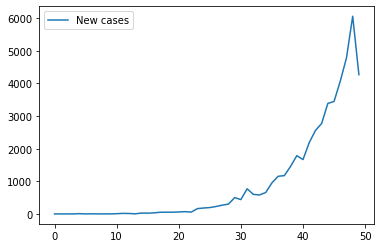

In [4]:
plt.plot(x_train, label="New cases")
plt.legend()
plt.show()

## Экспоненциальная модель

In [5]:
dummy_xs = np.arange(1, len(x_train)+1).reshape(-1, 1)
dummy_xs_all = np.arange(1, len(x_all)+1).reshape(-1, 1)

model = linear_model.LinearRegression(fit_intercept=True).fit( dummy_xs, np.log(x_train))


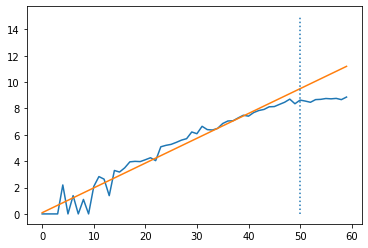

In [6]:
plt.plot( np.log(x_all) [:60])
plt.plot( model.predict(dummy_xs_all) [:60])
plt.vlines(len(x_train), 0, 15, linestyle="dotted")

In [7]:
def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = x.reshape(1, -1)
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

def get_poly_features(d, x):
    return np.array([ x ** i for i in range(d+1) ])

def myplot_sample_lines(ax, d, mu, sigma, xs, n=20, points=None):
    my_w = np.random.multivariate_normal(mu, sigma, n)

    for w in my_w:
        ax.plot(xs, np.dot(w, get_poly_features(d, xs)), 'k-', lw=.2, alpha=.5)
    if not points is None:
        ax.scatter(points[0], points[1], marker='*', s=200)

def train_poly_model(d, xs, ys, sigma_noise=.5):
    mu_0 = np.zeros(d+1)
    sigma_0 = 10 * np.identity(d+1)
    mu, sigma = mu_0, sigma_0
    for x,y in zip(xs, ys):
        mu, sigma = bayesian_update( mu, sigma, get_poly_features(d, x), y, sigma_noise=sigma_noise )
    return mu, sigma


In [8]:
mu, sigma = train_poly_model(1, np.arange(1, len(x_train)+1), np.log(x_train))
mu, sigma

(array([-0.09555021,  0.18822045]),
 array([[ 2.05698085e-02, -6.10984055e-04],
        [-6.10984055e-04,  2.39721391e-05]]))

### Предсказываем на определенные даты

In [9]:
dates = [28+30+1, 28+30+31+1, 28+30+31+30+31+31+1]
dates = np.array(dates).reshape(-1,1)
predicts = model.predict(dates)
print("Предсказание на 1 мая:\t\t", int(np.exp(predicts[0])))
print("Предсказание на 1 июня:\t\t", int(np.exp(predicts[1])))
print("Предсказание на 1 сентября:\t", int(np.exp(predicts[2])))

Предсказание на 1 мая:		 60452
Предсказание на 1 июня:		 20679400
Предсказание на 1 сентября:	 685732971818303


### Распределение

In [26]:
y = np.arange(1,51)
y = y.reshape(-1,1)

predicts_ = model.predict(y)

def do_sample(n,d,x,sigma_noise,mu,sigma):

    wx = mu.T@np.array([x**j for j in range(d+1)])
    return np.array([np.random.multivariate_normal(mu,sigma,n)[i]*np.prod([np.random.normal(wx[j],sigma_noise) for j in range(len(x))]) for i in range(n)])

print(do_sample(10, 1, np.exp(predicts_), .25, mu, sigma))


[[-2.01770366e+63 -7.80239353e+63]
 [ 2.31511509e+62 -1.36653213e+62]
 [-3.12764326e+62 -5.10269596e+63]
 [ 7.01793642e+62  4.25418152e+63]
 [-1.23725668e+62  4.67289471e+62]
 [ 2.14415323e+63 -6.60455233e+63]
 [ 2.87391332e+63 -3.97590228e+63]
 [-4.45554143e+63  2.17664588e+63]
 [ 3.76295977e+62 -6.72987855e+62]
 [-1.15401112e+62  2.68310008e+62]]


### Cэмплируем и рисуем прямые

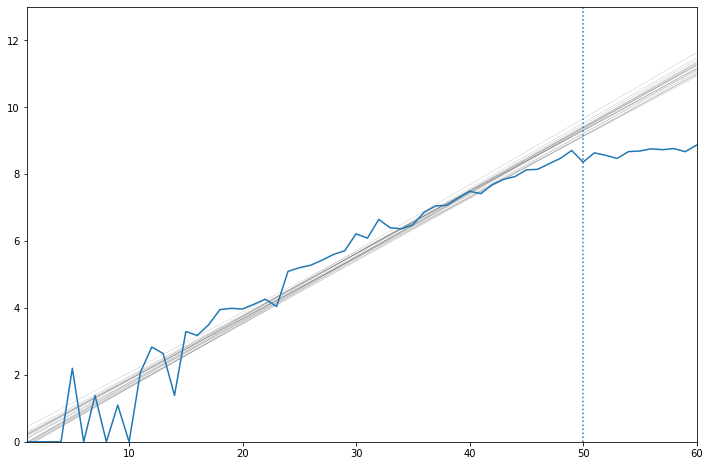

In [27]:
xs=np.arange(1, len(x_all) + 1)


fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((0, 20))
myplot_sample_lines(ax, 1, mu, sigma, xs, n=20)
ax.plot(xs, np.log(x_all) )
ax.vlines(len(x_train), 0, 15, linestyle="dotted")
ax.set_ylim((0, 13))
plt.show()

## Модель гауссиана

In [28]:
def modded_arr(x):
    return mu[0] + mu[1]*x + mu[2]*x**2 

In [29]:
x_all = data[data["total_cases"]>2]["new_cases"].to_numpy()
x_all = x_all[:300]
x_all[np.where(x_all == 0)] = 1
x_train = x_all[:100]

arange = np.arange(1,len(x_all)+1)
mu, sigma = train_poly_model(2, np.arange(1, len(x_train)+1), (np.log(x_train)))
mu

array([-0.70124241,  0.26943144, -0.00178063])

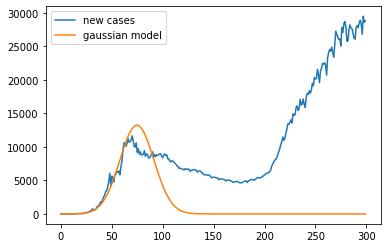

In [30]:
plt.plot((x_all), label="new cases")
plt.plot(np.exp(modded_arr(arange)), label="gaussian model")
plt.legend()
plt.show()

***Видно, что эта модель смогла описать только первую волну***

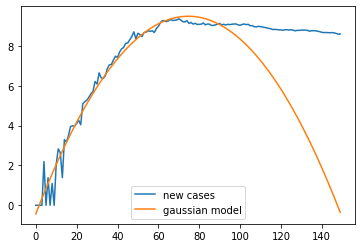

In [31]:
plt.plot(np.log(x_all[:150]), label="new cases")
plt.plot((modded_arr(arange[:150])), label="gaussian model")
plt.legend()
plt.show()

### Распределение

In [39]:
print(do_sample(10, 2, modded_arr(arange[:100]), .25, mu, sigma))


[[ 7.55940577e-06 -2.87625406e-06  1.89788420e-08]
 [ 2.87585066e-03 -1.25783140e-03  8.14727102e-06]
 [-1.32930121e-01  5.52432255e-02 -3.63018731e-04]
 [ 1.55086294e-02 -4.98545898e-03  3.23538500e-05]
 [-9.71803028e-07  3.38148681e-07 -2.20640942e-09]
 [ 1.28358319e-04 -4.88235606e-05  3.22022171e-07]
 [-3.08049399e-02  1.13403108e-02 -7.43793493e-05]
 [ 4.33705241e-05 -1.53453747e-05  1.02798827e-07]
 [-1.65045460e-03  6.20546097e-04 -4.12759676e-06]
 [-5.03533659e-04  1.48101400e-04 -9.78877110e-07]]


In [40]:
def myplot_sample_lines_counted(ax, d, mu, sigma, xs, n=20, points=None):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    all_predictions = []
    for w in my_w:
        predicted_cases = np.dot(w, get_poly_features(d,xs))
        ax.plot(xs, predicted_cases, 'k-', lw=.2, alpha=.5)
        predicted_cases = predicted_cases[predicted_cases > 0]
        all_predictions += [np.sum(np.exp(predicted_cases))]
    if not points is None:
        ax.scatter(points[0], points[1], marker='*', s=200)
    return np.array(all_predictions)

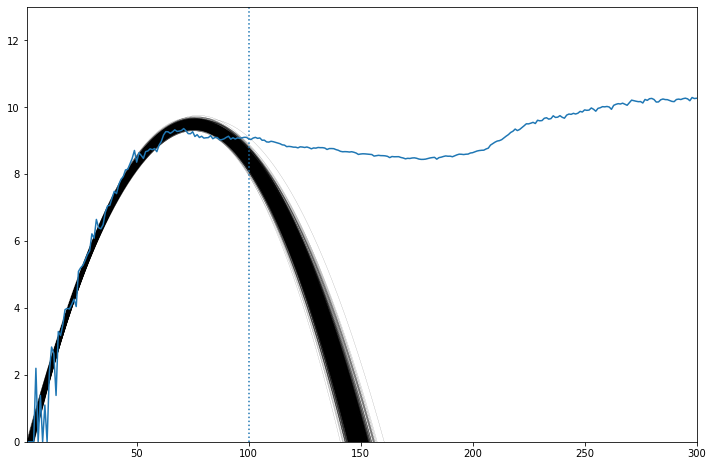

In [41]:
xs=np.arange(1, len(x_all) + 1)


fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((0, 20))
preds = myplot_sample_lines_counted(ax, 2, mu, sigma, xs, n=2000)
ax.plot(xs, np.log(x_all) )
ax.vlines(len(x_train), 0, 15, linestyle="dotted")
ax.set_ylim((0, 13))
plt.show()

### Количество переболевших

In [42]:
print("90% quantile:\t", np.quantile(preds,0.9))
print("10% quantile:\t", np.quantile(preds,0.1))

90% quantile:	 607591.2364381135
10% quantile:	 510615.13231523434
